<a href="https://githubtocolab.com/ml-for-high-risk-apps-book/Machine-Learning-for-High-Risk-Applications-Book/blob/main/code/Chapter-10/Testing_and_Remediating_Bias_constrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 10: Testing and Remediating Bias in an XGBoost Credit Model

## 1. Setting the environment

Download the [zipped **Data** folder](https://github.com/ml-for-high-risk-apps-book/Machine-Learning-for-High-Risk-Applications-Book/blob/main/code/data_and_package.zip) onto your local system and save it as `Data.zip`. 

In [ ]:
# Upload the downloaded zipped file from your system to the colab environment. 
from google.colab import files
uploaded = files.upload()

In [ ]:
!unzip -q "/content/Data.zip" 
%cd /content/Data

In [ ]:
# Installing the libraries
%pip install h2o 
%pip install shap
%pip install 'XGBoost==1.6'

## 2. Evaluating an XGBoost Model




### Train the Model

- Since the Disparate Impact Analysis(DIA) analysis will focus on model outcomes (rather than scores), choose a cutoff in probability space.


In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sklearn

import shap
np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')


In [2]:
data = pd.read_csv('../Data/Data/credit_line_increase.csv')

data['SEX'] = np.where(data['SEX'] == 1, 'male', 'female')
race_map = {1: 'hispanic', 2: 'black', 3: 'white', 4: 'asian'}
data['RACE'] = data['RACE'].apply(lambda x: race_map[x])

In [3]:
# Modify the data so there is a distributional difference between borrowers of different race/ethnicities.

new_limit_bal = data['LIMIT_BAL'] - 20000*np.random.randn(len(data))
new_limit_bal[new_limit_bal <= 10000] = 10000
data['LIMIT_BAL'] = np.where((data['RACE'] == 'hispanic') | (data['RACE'] == 'black'), 
                             new_limit_bal, 
                             data['LIMIT_BAL'])

for i in range(1, 7):
    delta = 1000*np.random.randn(len(data))
    new_pay = data[f'PAY_AMT{i}'] - delta
    new_pay[new_pay < 0] = 0

    new_bill = data[f'BILL_AMT{i}'] - delta
    new_bill[new_bill < 0] = 0

    data[f'PAY_AMT{i}'] = np.where((data['RACE'] == 'hispanic') | (data['RACE'] == 'black'), 
                                   new_pay, 
                                   data[f'PAY_AMT{i}'])
    data[f'BILL_AMT{i}'] = np.where((data['RACE'] == 'hispanic') | (data['RACE'] == 'black'), 
                                    new_bill, 
                                    data[f'BILL_AMT{i}']) 


In [4]:
seed = 12345
np.random.seed(seed)

split_train_test = 2/3

split = np.random.rand(len(data)) < split_train_test
train = data[split].copy()
test = data[~split].copy()

split_test_valid = 1/2

split = np.random.rand(len(test)) < split_test_valid
valid = test[split].copy()
test = test[~split].copy()

del data

print(f"Train/Validation/Test sizes: {len(train)}/{len(valid)}/{len(test)}")

Train/Validation/Test sizes: 19919/5045/5036


In [5]:
id_col = 'ID'
groups = ['SEX', 'RACE', 'EDUCATION', 'MARRIAGE', 'AGE']
target = 'DELINQ_NEXT'
features = [col for col in train.columns if col not in groups + [id_col, target]]

dtrain = xgb.DMatrix(train[features], 
                     label=train[target])

dvalid = xgb.DMatrix(valid[features], 
                     label=valid[target])

In [6]:
corr = pd.DataFrame(train[features + [target]].corr(method='spearman')[target]).iloc[:-1]

def get_monotone_constraints(data, target, corr_threshold):
    """Calculate monotonic constraints.
    
    Using a cutoff on Spearman correlation between features and target, return a tuple ready to pass into XGBoost. 

    
    Args:
        data (pd.DataFrame): A DataFrame containing the features in the order they appear to XGBoost, as well as the target variable.
        target (str): The name of the column with the target variable in 'data'.
        corr_threshold (float): The Spearman correlation threshold.

    Returns:
        tuple: A tuple with values in {-1, 0, 1}, where each element corresponds to a column in data (excluding the target itself). Ready to pass into xgb.train()

    """
    
    corr = pd.Series(data.corr(method='spearman')[target]).drop(target)
    monotone_constraints = tuple(np.where(corr < -corr_threshold, 
                                          -1, 
                                          np.where(corr > corr_threshold,
                                                   1, 
                                                   0)))
    return monotone_constraints

correlation_cutoff = 0.1

monotone_constraints = get_monotone_constraints(train[features+[target]],
                                                target,
                                                correlation_cutoff)

In [7]:
# Feed the model the global bias
base_score = train[target].mean()

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.05,
    'subsample': 0.6,
    'colsample_bytree': 1.0,
    'max_depth': 5,
    'base_score': base_score,
    'monotone_constraints': dict(zip(features, monotone_constraints)),
    'seed': seed
}

# Train using early stopping on the validation dataset.
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

model_constrained = xgb.train(params,         
                              dtrain,                   
                              num_boost_round=200,                     
                              evals=watchlist,
                              early_stopping_rounds=10,
                              verbose_eval=False)

train[f'p_{target}'] = model_constrained.predict(dtrain)
valid[f'p_{target}'] = model_constrained.predict(dvalid)
test[f'p_{target}'] = model_constrained.predict(xgb.DMatrix(test[features], label=test[target]))

In [8]:
# Select the optimal probability cutoff by maximizing the F1 score on validation data. 

def perf_metrics(y_true, y_score, pos=1, neg=0, res=0.01):
    """ 
    Calculates precision, recall, and f1 given outcomes and probabilities.
    
    Args:
        y_true: Array of binary outcomes
        y_score: Array of assigned probabilities.
        pos: Primary target value, default 1.
        neg: Secondary target value, default 0.
        res: Resolution by which to loop through cutoffs, default 0.01.
    
    Returns:
        Pandas dataframe of precision, recall, and f1 values. 
    """
    
    eps = 1e-20 # for safe numerical operations
    
    # init p-r roc frame
    prauc_frame = pd.DataFrame(columns=['cutoff', 'recall', 'precision', 'f1'])
    
    # loop through cutoffs to create p-r roc frame
    for cutoff in np.arange(0, 1 + res, res):

        # binarize decision to create confusion matrix values
        decisions = np.where(y_score > cutoff , 1, 0)
        
        # calculate confusion matrix values
        tp = np.sum((decisions == pos) & (y_true == pos))
        fp = np.sum((decisions == pos) & (y_true == neg))
        tn = np.sum((decisions == neg) & (y_true == neg))
        fn = np.sum((decisions == neg) & (y_true == pos))
        
        # calculate precision, recall, and f1
        recall = (tp + eps)/((tp + fn) + eps)
        precision = (tp + eps)/((tp + fp) + eps)
        f1 = 2/((1/(recall + eps)) + (1/(precision + eps)))
        
        # add new values to frame
        prauc_frame = prauc_frame.append({'cutoff': cutoff,
                                          'recall': recall,
                                          'precision': precision,
                                          'f1': f1}, 
                                          ignore_index=True)
        
    return prauc_frame


model_metrics = perf_metrics(y_true=valid[target], y_score=model_constrained.predict(dvalid))


In [9]:
model_metrics.loc[model_metrics['f1'].idxmax()]

cutoff       0.260000
recall       0.610773
precision    0.541602
f1           0.574112
Name: 26, dtype: float64

Text(0.5, 0, 'Score Cutoff')

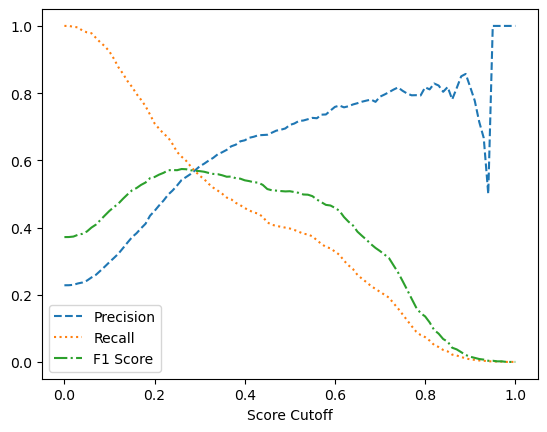

In [10]:
best_cut = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']
best_cut_original = best_cut

fig, ax = plt.subplots()
ax.plot(model_metrics['cutoff'], model_metrics['precision'], label='Precision',linestyle='--')
ax.plot(model_metrics['cutoff'], model_metrics['recall'], label='Recall',linestyle=':')
ax.plot(model_metrics['cutoff'], model_metrics['f1'], label='F1 Score',linestyle='-.')
ax.legend(loc=3)
ax.set_xlabel('Score Cutoff')


In [11]:
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5):
    """ 
    Creates confusion matrix from pandas dataframe of y and yhat values, can be sliced by a variable and level.
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        by: By variable to slice frame before creating confusion matrix, default None.
        level: Value of by variable to slice frame before creating confusion matrix, default None.
        cutoff: Cutoff threshold for confusion matrix, default 0.5. 

    Returns:
        Confusion matrix as pandas dataframe. 
    """
    
    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True)

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list], 
                            index=['predicted: ' + str(i) for i in level_list])
    
    # don't destroy original data
    frame_ = frame.copy(deep=True)
    
    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
    
    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]
    
    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[j, i] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]
    
    return cm_frame

get_confusion_matrix(test, target, f'p_{target}', cutoff=best_cut)

,actual: 1,actual: 0
predicted: 1,655,592
predicted: 0,442,3347


### Confusion Matrix Disparity Metrics

In [12]:
metric_dict = {
'Prevalence': '(tp + fn) / (tp + tn +fp + fn)', # how much default actually happens for this group
'Accuracy': '(tp + tn) / (tp + tn + fp + fn)', # how often the model predicts default and non-default correctly for this group
'True Positive Rate': 'tp / (tp + fn)',  # out of the people in the group *that did* default, how many the model predicted *correctly* would default              
'Precision': 'tp / (tp + fp)',  # out of the people in the group the model *predicted* would default, how many the model predicted *correctly* would default
'Specificity': 'tn / (tn + fp)', # out of the people in the group *that did not* default, how many the model predicted *correctly* would not default
'Negative Predicted Value': 'tn / (tn + fn)', # out of the people in the group the model *predicted* would not default, how many the model predicted *correctly* would not default  

'False Positive Rate': 'fp / (tn + fp)', # out of the people in the group *that did not* default, how many the model predicted *incorrectly* would default
'False Discovery Rate': 'fp / (tp + fp)', # out of the people in the group the model *predicted* would default, how many the model predicted *incorrectly* would default

'False Negative Rate': 'fn / (tp + fn)', # out of the people in the group *that did* default, how many the model predicted *incorrectly* would not default
'False Omissions Rate': 'fn / (tn + fn)'  # out of the people in the group the model *predicted* would not default, how many the model predicted *incorrectly* would not default
}


def confusion_matrix_parser(expression):
    
    # tp | fp       cm_dict[level].iat[0, 0] | cm_dict[level].iat[0, 1]
    # -------  ==>  --------------------------------------------
    # fn | tn       cm_dict[level].iat[1, 0] | cm_dict[level].iat[1, 1]

    expression = expression.replace('tp', 'cm_dict[level].iat[0, 0]')\
                           .replace('fp', 'cm_dict[level].iat[0, 1]')\
                           .replace('fn', 'cm_dict[level].iat[1, 0]')\
                           .replace('tn', 'cm_dict[level].iat[1, 1]')

    return expression

In [13]:
# initialize dict of confusion matrices and corresponding rows of dataframe
sex_confusion_mats = {'male': get_confusion_matrix(test, target, 
                                                   f'p_{target}', by='SEX', 
                                                   level='male', cutoff=best_cut), 
                      'female': get_confusion_matrix(test, target, 
                                                     f'p_{target}', by='SEX', 
                                                     level='female', cutoff=best_cut)} 

def confusion_matrix_metrics(cm_dict, metric_dict):
    levels = list(cm_dict.keys())

    metrics_frame = pd.DataFrame(index=levels) # frame for metrics

    for level in levels:
        for metric in metric_dict.keys():

            # parse metric expressions into executable pandas statements
            expression = confusion_matrix_parser(metric_dict[metric])

            # dynamically evaluate metrics to avoid code duplication
            metrics_frame.loc[level, metric] = eval(expression)  

    return metrics_frame

sex_confusion_metrics = confusion_matrix_metrics(sex_confusion_mats, metric_dict)

In [14]:
sex_confusion_metrics

,Prevalence,Accuracy,True Positive Rate,Precision,Specificity,Negative Predicted Value,False Positive Rate,False Discovery Rate,False Negative Rate,False Omissions Rate
male,0.238264,0.779404,0.599576,0.532957,0.835653,0.869655,0.164347,0.467043,0.400424,0.130345
female,0.204583,0.804583,0.595200,0.519553,0.858436,0.891834,0.141564,0.480447,0.404800,0.108166


In [15]:
race_levels = list(race_map.values())
race_confusion_mats = {level: get_confusion_matrix(test, target, f'p_{target}', by='RACE', 
                                                   level=level, cutoff=best_cut) for level in race_levels} 
race_confusion_metrics = confusion_matrix_metrics(race_confusion_mats, metric_dict)

In [16]:
race_confusion_metrics

,Prevalence,Accuracy,True Positive Rate,Precision,Specificity,Negative Predicted Value,False Positive Rate,False Discovery Rate,False Negative Rate,False Omissions Rate
hispanic,0.399393,0.725986,0.637975,0.663158,0.784512,0.765189,0.215488,0.336842,0.362025,0.234811
black,0.386707,0.720040,0.635417,0.638743,0.773399,0.770867,0.226601,0.361257,0.364583,0.229133
white,0.107075,0.829828,0.470238,0.307393,0.872948,0.932165,0.127052,0.692607,0.529762,0.067835
asian,0.101010,0.853199,0.533333,0.350877,0.889139,0.944312,0.110861,0.649123,0.466667,0.055688


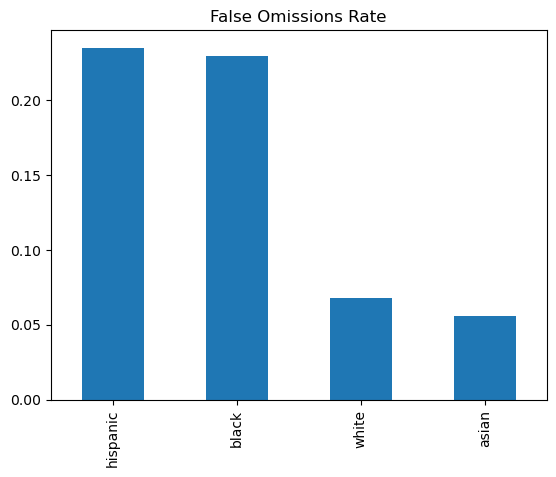

In [17]:
_ = race_confusion_metrics['False Omissions Rate'].plot(kind='bar', title='False Omissions Rate')

In [18]:
race_disparity_frame = race_confusion_metrics/race_confusion_metrics.loc['white', :]
race_disparity_frame.columns=[col + ' Disparity' for col in race_confusion_metrics.columns]

# small utility function to format pandas table output
def disparate_red(val, parity_threshold_low=0.8, parity_threshold_hi=1.25):
    color = 'grey' if (parity_threshold_low < val < parity_threshold_hi) else 'red'
    return 'color: %s' % color 

race_disparity_frame.style.applymap(disparate_red)

,Prevalence Disparity,Accuracy Disparity,True Positive Rate Disparity,Precision Disparity,Specificity Disparity,Negative Predicted Value Disparity,False Positive Rate Disparity,False Discovery Rate Disparity,False Negative Rate Disparity,False Omissions Rate Disparity
hispanic,3.730048,0.874863,1.356706,2.157362,0.898693,0.820873,1.696062,0.486339,0.683374,3.461486
black,3.611567,0.867698,1.351266,2.077938,0.885962,0.826965,1.783528,0.521590,0.688202,3.377775
white,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
asian,0.943362,1.028163,1.134177,1.141461,1.018547,1.013031,0.872567,0.937217,0.880899,0.820931


In [19]:
sex_disparity_frame = sex_confusion_metrics/sex_confusion_metrics.loc['male', :]
sex_disparity_frame.columns=[col + ' Disparity' for col in sex_confusion_metrics.columns]

# small utility function to format pandas table output
def disparate_red(val, parity_threshold_low=0.8, parity_threshold_hi=1.25):
    color = 'grey' if (parity_threshold_low < val < parity_threshold_hi) else 'red'
    return 'color: %s' % color 

sex_disparity_frame.style.applymap(disparate_red)

,Prevalence Disparity,Accuracy Disparity,True Positive Rate Disparity,Precision Disparity,Specificity Disparity,Negative Predicted Value Disparity,False Positive Rate Disparity,False Discovery Rate Disparity,False Negative Rate Disparity,False Omissions Rate Disparity
male,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
female,0.858640,1.032305,0.992701,0.974850,1.027264,1.025503,0.861370,1.028699,1.010929,0.829844


### Fair Lending Disparity Analysis

In [20]:
from scipy.stats import ttest_ind, chisquare, fisher_exact, chi2_contingency


def air_statistical_signif(group_count, group_favorable, reference_count, reference_favorable):
    # Perform a chi-square test 
    # (or Fisher's exact when cells in the contingency test have less than 30 individuals in them).
    
    group_unfavorable = group_count - group_favorable
    reference_unfavorable = reference_count - reference_favorable
    
    contingency_table = np.array([[group_favorable, group_unfavorable], 
                                  [reference_favorable, reference_unfavorable]])
    
    if np.min(contingency_table) < 30:
        _, p = fisher_exact(contingency_table)
    else:
        _, p, _, _ = chi2_contingency(contingency_table)
    
    return p

def smd_statistical_signif(group_scores, reference_scores):
    # Perform a one-sided t-test. An outcome of 1 is assumed to be favorable. 
    
    # We do not assume that the two scores have equal variance. Furthermore, we are testing 
    # against the alternative hypothesis that the group receives lower scores than the reference
    # group.
    _, p = ttest_ind(group_scores, reference_scores, equal_var=False, alternative='less')
    return p


def fair_lending_disparity(frame, y, yhat, demo_name, groups, reference_group, cutoff=0.5, favorable_outcome=0):
    """ 
    Creates a table of fair lending disparity metrics (AIR and SMD).
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values with group membership.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        demo_name: The name of the column containing the group information
        groups: The names of the groups in the demo_name column.
        reference_group: The control group.
        cutoff: Cutoff threshold for confusion matrix, default 0.5. 
        favorable_outcome: The value {0, 1} that corresponds to a desirable outcome.

    Returns:
        A DataFrame summarizing the fair lending metrics analysis
    """
    
    protected_groups = [group for group in groups if group != reference_group]
    groups_ordered = protected_groups + [reference_group]   
    
    temp_frame = frame.copy()
    temp_frame['model_outcome'] = np.where(temp_frame[yhat] <= cutoff, 0, 1)
    temp_frame['fav_outcome'] = temp_frame['model_outcome'] == favorable_outcome
    temp_frame['fav_score'] = temp_frame[yhat] if favorable_outcome else 1-temp_frame[yhat]
    
    disparity_table = pd.DataFrame(index=groups_ordered)
    
    disparity_table['Count'] = [len(temp_frame.loc[temp_frame[demo_name] == group]) for group in groups_ordered]
    disparity_table['Favorable Outcomes'] = [temp_frame.loc[temp_frame[demo_name] == group]['fav_outcome'].sum() 
                                             for group in groups_ordered]
    disparity_table['Favorable Rate'] = [disparity_table['Favorable Outcomes'][group]/disparity_table['Count'][group] 
                                         for group in groups_ordered]
    disparity_table['Mean Score'] = [temp_frame.loc[temp_frame[demo_name] == group][yhat].mean() 
                                             for group in groups_ordered]
    disparity_table['Std Score'] = [temp_frame.loc[temp_frame[demo_name].isin([reference_group, group])][yhat].std() 
                                             for group in groups_ordered]
    try:
        disparity_table['AIR'] = [disparity_table['Favorable Rate'][group]/disparity_table['Favorable Rate'][reference_group] 
                                  for group in groups_ordered]
    except:
        disparity_table['AIR'] = np.nan
        
    disparity_table['AIR p-value'] = [air_statistical_signif(disparity_table['Count'][group], 
                                                             disparity_table['Favorable Outcomes'][group],
                                                             disparity_table['Count'][reference_group],
                                                             disparity_table['Favorable Outcomes'][reference_group])
                                      for group in groups_ordered]

    disparity_table['SMD'] = [(disparity_table['Mean Score'][group] - 
                               disparity_table['Mean Score'][reference_group]) / 
                              disparity_table['Std Score'][group]
                              for group in groups_ordered]
    
    disparity_table['SMD p-value'] = [smd_statistical_signif(temp_frame.loc[temp_frame[demo_name] == group]['fav_score'],
                                                             temp_frame.loc[temp_frame[demo_name] == reference_group]['fav_score'])
                                      for group in groups_ordered]

    return disparity_table
    

In [21]:
fair_lending_disparity(train, y=target, yhat=f'p_{target}', 
                       demo_name='RACE', groups=race_levels, reference_group='white', 
                       cutoff=best_cut)

,Count,Favorable Outcomes,Favorable Rate,Mean Score,Std Score,AIR,AIR p-value,SMD,SMD p-value
hispanic,3828,2291,0.598485,0.293440,0.200466,0.707605,5.460221e-169,0.582584,1.495956e-155
black,3795,2292,0.603953,0.290833,0.199664,0.714070,5.964702e-162,0.571868,9.077000e-149
asian,6181,5259,0.850833,0.173872,0.162106,1.005964,4.505482e-01,-0.017151,8.291354e-01
white,6115,5172,0.845789,0.176652,0.163658,1.000000,1.000000e+00,0.000000,5.000000e-01


In [22]:
fair_lending_disparity(valid, y=target, yhat=f'p_{target}', 
                       demo_name='RACE', groups=race_levels, reference_group='white', 
                       cutoff=best_cut)

,Count,Favorable Outcomes,Favorable Rate,Mean Score,Std Score,AIR,AIR p-value,SMD,SMD p-value
hispanic,1016,610,0.600394,0.290456,0.204616,0.726036,3.513458e-37,0.507062,1.137735e-33
black,1008,633,0.627976,0.280488,0.203442,0.759391,1.069313e-29,0.460991,7.053854e-28
asian,1455,1209,0.830928,0.187016,0.175111,1.004813,8.088640e-01,0.001787,4.804269e-01
white,1566,1295,0.826948,0.186703,0.175511,1.000000,1.000000e+00,0.000000,5.000000e-01


In [23]:
fair_lending_disparity(test, y=target, yhat=f'p_{target}', 
                       demo_name='RACE', groups=race_levels, reference_group='white', 
                       cutoff=best_cut)

,Count,Favorable Outcomes,Favorable Rate,Mean Score,Std Score,AIR,AIR p-value,SMD,SMD p-value
hispanic,989,609,0.615774,0.291994,0.205374,0.736394,6.803832e-36,0.528829,4.311283e-35
black,993,611,0.615307,0.279935,0.199937,0.735836,4.343885e-36,0.482898,4.564904e-30
asian,1485,1257,0.846465,0.177847,0.169855,1.012274,4.677908e-01,-0.032609,8.162671e-01
white,1569,1312,0.836201,0.183386,0.172153,1.000000,1.000000e+00,0.000000,5.000000e-01


### Individual Fairness Analysis

In [24]:
def plot_group_residuals(frame, y, yhat, demo_name, groups, cutoff=0.5, favorable_outcome=0):
    """ 
    Generates a plot of logloss residuals for individuals who falsely received an unfavorable outcome.
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values with group membership.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        demo_name: The name of the column containing the group information
        groups: The names of the groups in the demo_name column.
        cutoff: Cutoff threshold for confusion matrix, default 0.5. 
        favorable_outcome: The value {0, 1} that corresponds to a desirable outcome.

    Returns:
        Axes of the plot
    """
    
    fig, axs = plt.subplots(1, len(groups), figsize=(5*len(groups), 5))
    for i, group in enumerate(groups):
        group_frame = frame.loc[frame[demo_name] == group].copy()
        group_frame[f'{yhat}_outcome'] = np.where(group_frame[yhat] > cutoff, 1, 0)
        
        group_frame[f'{y}_residual'] = -group_frame[y]*np.log(group_frame[yhat]) 
        group_frame[f'{y}_residual'] -= (1 - group_frame[y])*np.log(1 - group_frame[yhat]) 
        
        misclassified_obs = group_frame[(group_frame[y] == favorable_outcome) & 
                                        (group_frame[f'{yhat}_outcome'] == (1 - favorable_outcome))]
        axs[i].scatter(misclassified_obs[yhat], misclassified_obs[f'{y}_residual'], marker='o', alpha=0.3)
        axs[i].set_xlabel('Score')
        axs[i].set_ylabel('Residual')
        axs[i].set_title(group)
        axs[i].set_xlim([0, 1])
        axs[i].set_ylim([0, 2])

    fig.suptitle('Logloss Residuals')
    
    return axs

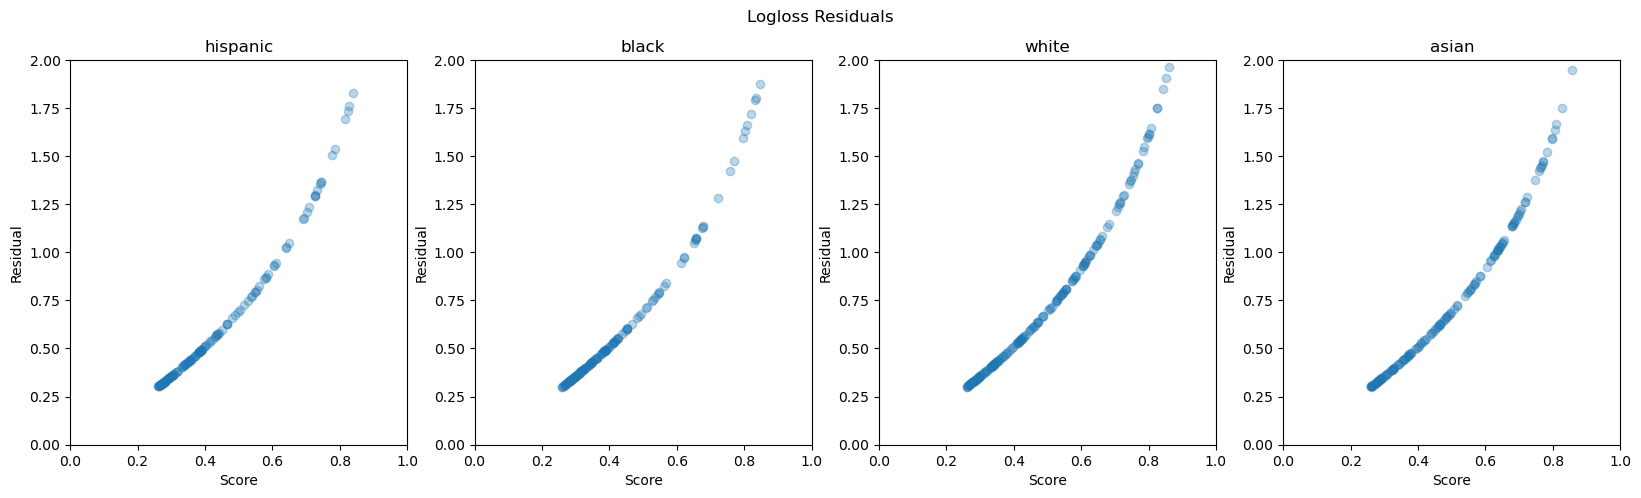

In [25]:
_ = plot_group_residuals(test, y=target, yhat=f'p_{target}', 
                       demo_name='RACE', groups=race_levels,
                       cutoff=best_cut)


In [26]:
# Examine outlying misclassified black observations

black_obs = valid.loc[valid['RACE'] == 'black'].copy()
black_obs[f'p_{target}_outcome'] = np.where(black_obs[f'p_{target}'] > best_cut, 1, 0)
        
misclassified_obs = black_obs[(black_obs[target] == 0) & 
                              (black_obs[f'p_{target}_outcome'] == 1)]

misclassified_obs.sort_values(by=f'p_{target}').head(3)[features]

,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
18410,58149.491706,-1,-1,-2,-2,-2,-2,598.365005,711.831713,0.00000,907.724241,279.584857,0.000000,208.365005,711.831713,0.000000,907.724241,279.584857,0.000000
7464,57774.073318,0,0,0,-1,-1,-1,8536.182124,5059.218985,0.00000,796.058614,0.000000,1398.080985,745.182124,149.218985,29.447602,122.058614,720.411608,4831.080985
5813,166836.432637,-1,-1,-1,0,0,-1,0.000000,0.000000,577.77001,825.081830,0.000000,5037.110450,0.000000,0.000000,0.000000,132.081830,3395.646898,1062.110450


In [27]:
# We'll train an adversarial model that attempts to predict each observations' race/ethnicity (black/hispanic 
#  or asian/white). Compare an adversary that doesn't have access to the model's predictions with one
#  that does. If the model predictions meaningfully improve the performance of the adversary for certain
#  observations, there is a potential individual fairness concern.

train['protected'] = np.where((train['RACE'] == 'hispanic') | (train['RACE'] == 'black'), 1, 0)
valid['protected'] = np.where((valid['RACE'] == 'hispanic') | (valid['RACE'] == 'black'), 1, 0)

dtrain_adversary = xgb.DMatrix(train[features], 
                     label=train['protected'])

dvalid_adversary = xgb.DMatrix(valid[features], 
                     label=valid['protected'])

base_score_adversary = train['protected'].mean()

params_adversary = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.05,
    'subsample': 0.75,
    'colsample_bytree': 0.8,
    'max_depth': 5,
    'base_score': base_score_adversary,
    'seed': seed
}

# Train using early stopping on the validation dataset.
watchlist_adversary = [(dtrain_adversary, 'train'), (dvalid_adversary, 'eval')]

adversary_model = xgb.train(params,         
                              dtrain_adversary,                   
                              num_boost_round=200,                     
                              evals=watchlist_adversary,
                              early_stopping_rounds=10,
                              verbose_eval=False)

In [28]:
dtrain_adversary_ii = xgb.DMatrix(train[features + [f'p_{target}']], 
                     label=train['protected'])

dvalid_adversary_ii = xgb.DMatrix(valid[features + [f'p_{target}']], 
                     label=valid['protected'])

watchlist_adversary_ii = [(dtrain_adversary_ii, 'train'), (dvalid_adversary_ii, 'eval')]

adversary_model_ii = xgb.train(params,         
                              dtrain_adversary_ii,                   
                              num_boost_round=200,                     
                              evals=watchlist_adversary_ii,
                              early_stopping_rounds=10,
                              verbose_eval=False)

In [29]:
adversarial_outputs = pd.DataFrame({'protected': valid['protected'],
                                    'P(protected) (1)': adversary_model.predict(dvalid_adversary),
                                    'P(protected) (2)': adversary_model_ii.predict(dvalid_adversary_ii)})

In [30]:
adversarial_outputs['delta'] = adversarial_outputs['P(protected) (2)'] - adversarial_outputs['P(protected) (1)']
adversarial_outputs.loc[adversarial_outputs['protected'] == 1].sort_values('delta', ascending=False)

,protected,P(protected) (1),P(protected) (2),delta
9022,1,0.288018,0.591721,0.303703
7319,1,0.383856,0.658186,0.274330
528,1,0.502449,0.771791,0.269342
22794,1,0.445786,0.695297,0.249511
27466,1,0.418545,0.654413,0.235868
...,...,...,...,...
4857,1,0.798855,0.570670,-0.228185
5411,1,0.697337,0.442306,-0.255031
2532,1,0.698753,0.439587,-0.259166
8392,1,0.593573,0.299124,-0.294449


In [31]:
most_affected_obs = adversarial_outputs.sort_values('delta', ascending=False).index[:5]
most_affected_obs 

Int64Index([10201, 8479, 12101, 22479, 24760], dtype='int64')

In [32]:
valid.loc[24497]

ID                      24498
LIMIT_BAL        35844.470164
SEX                      male
RACE                    black
EDUCATION                   1
MARRIAGE                    2
AGE                        36
PAY_0                      -1
PAY_2                       2
PAY_3                       2
PAY_4                      -1
PAY_5                      -1
PAY_6                      -2
BILL_AMT1          393.000384
BILL_AMT2           161.61234
BILL_AMT3                 0.0
BILL_AMT4         1038.465074
BILL_AMT5          186.063655
BILL_AMT6                 0.0
PAY_AMT1                  0.0
PAY_AMT2                  0.0
PAY_AMT3          6016.681659
PAY_AMT4           678.465074
PAY_AMT5           216.063655
PAY_AMT6                  0.0
DELINQ_NEXT                 1
p_DELINQ_NEXT        0.272676
protected                   1
Name: 24497, dtype: object

In [33]:
explanation_data = valid[features + [f'p_{target}']]

adversarial_shap_values = shap.TreeExplainer(adversary_model_ii).shap_values(explanation_data)

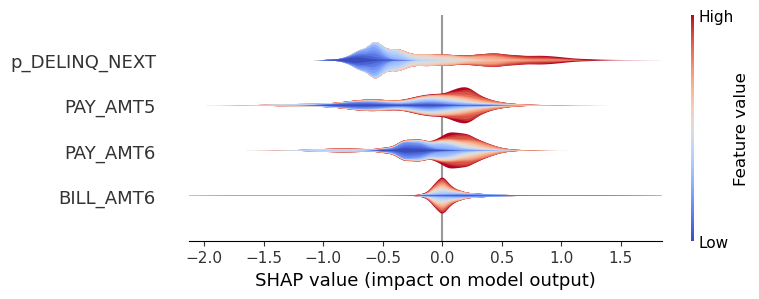

In [34]:
# Observe that higher model scores result in a positive contribution to the protected group prediction, however
# the relationship is nonlinear (the color gradient for p_DELINQ_NEXT does not smoothly move from cool to hot). 
# This suggests there are feature interactions with p_DELINQ_NEXT that are contributing towards the adversarial
# model prediction - these are interactions to investigate for proxy effects. 

shap.summary_plot(adversarial_shap_values, 
                  explanation_data, 
                  plot_type="layered_violin", 
                  color='coolwarm', max_display=4, show=False)

fig = plt.gcf()
#fig.savefig('../Data/Data/Figures/shap_summary_violin.png', bbox_inches='tight')

(-1.1108994156122207, 1.9821324080228806)

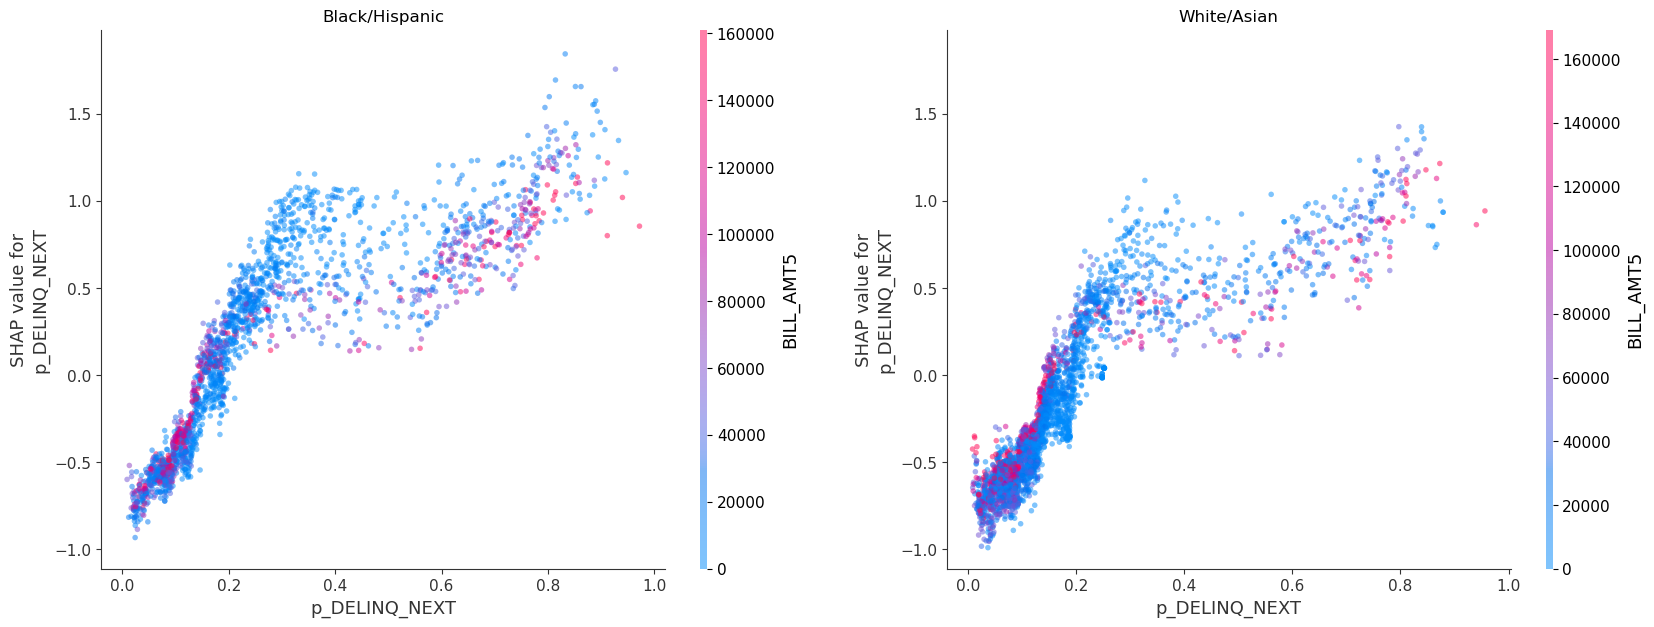

In [35]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 7))

shap.dependence_plot('p_DELINQ_NEXT', 
                     adversarial_shap_values[valid['protected'] == 1], 
                     explanation_data.loc[valid['protected'] == 1],
                     interaction_index='BILL_AMT5',
                     alpha=0.5,
                     ax=ax0,
                     show=False)

ax0.set_title('Black/Hispanic')

shap.dependence_plot('p_DELINQ_NEXT', 
                     adversarial_shap_values[valid['protected'] == 0], 
                     explanation_data.loc[valid['protected'] == 0],
                     interaction_index='BILL_AMT5',
                     alpha=0.5,
                     ax=ax1,
                     show=False)

ax1.set_title('White/Asian')

ylim = (np.min([ax0.get_ylim()[0], ax1.get_ylim()[0]]), 
        np.max([ax0.get_ylim()[1], ax1.get_ylim()[1]]))
               
ax0.set_ylim(ylim)
ax1.set_ylim(ylim)

In [36]:
# Calculate interaction values for the top 100 observations that had their predictions change the most
#  from adversary i to adversary ii.

explainer = shap.TreeExplainer(adversary_model_ii)
expected_value = explainer.expected_value[0]

In [37]:
explanation_data = valid[features + [f'p_{target}']] #  .loc[most_affected_obs]

shap_values = explainer.shap_values(explanation_data)
shap_interaction_values = explainer.shap_interaction_values(explanation_data)

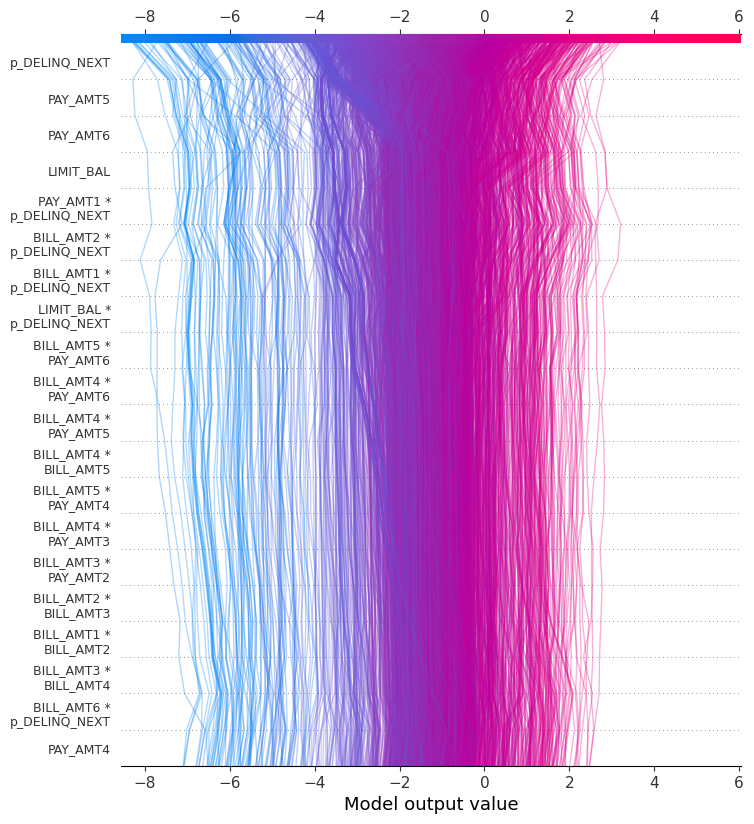

In [38]:
# shap.decision_plot(expected_value, shap_interaction_values, feature_names=features + [f'p_{target}'], link='logit',
#                   ignore_warnings=True, alpha=0.3)

shap.decision_plot(expected_value, shap_interaction_values, feature_names=features + [f'p_{target}'],
                  ignore_warnings=True, alpha=0.3, feature_order='hclust')

In [39]:
highlight_obs = np.where(valid.index.isin(most_affected_obs), 1, 0)

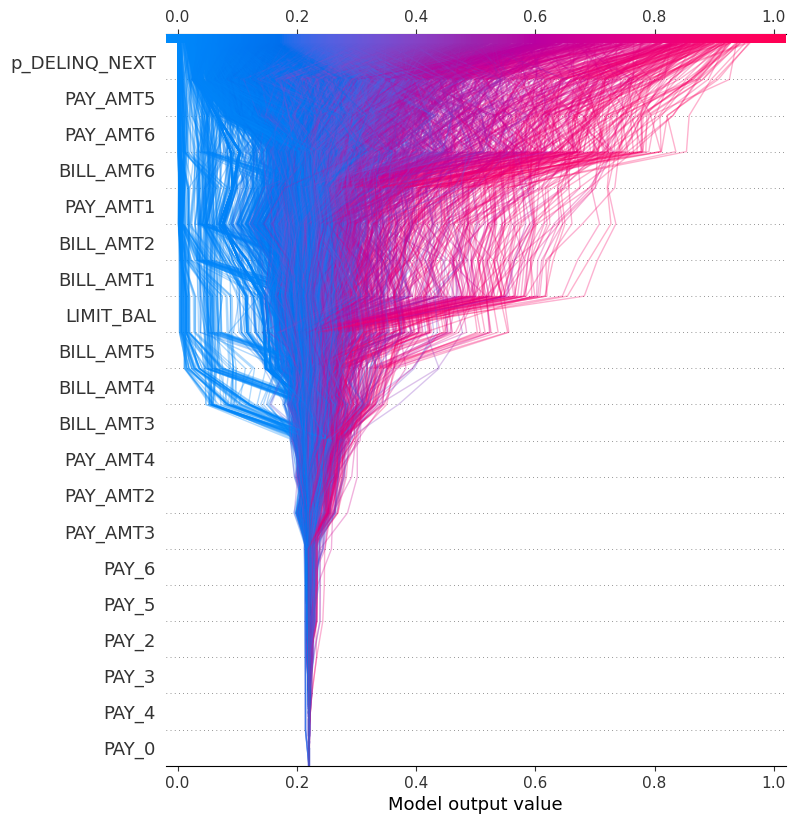

In [40]:
shap.decision_plot(expected_value, shap_values, feature_names=features + [f'p_{target}'], 
                   link='logit', ignore_warnings=True, alpha=0.3, highlight=highlight_obs)

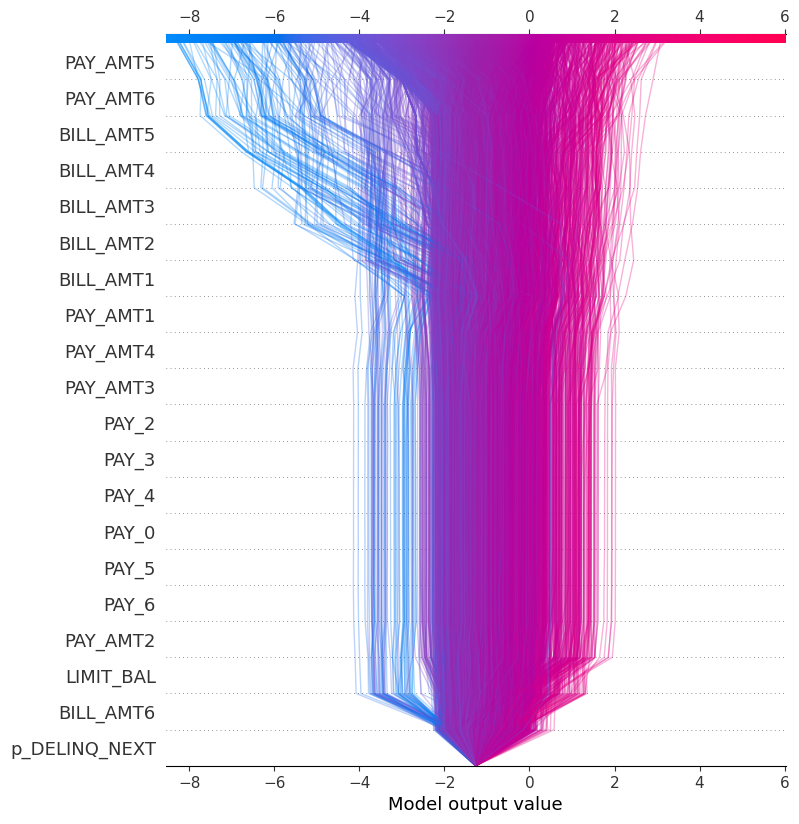

In [41]:
shap.decision_plot(expected_value, shap_values, 
                   feature_names=features + [f'p_{target}'], 
                   feature_order='hclust',
                   ignore_warnings=True, alpha=0.3)

## 3. Remediating Model Bias

### Pre-Processing

In [42]:
def reweight_dataset(frame, y, demo_name, groups):
    """
    Generates a weight for each observation according to the reweighting algorithm of 
    Kamiran and Kalders 2012, Data preprocessing techniques for classification without discrimination.
    
    Args:
        frame: Pandas dataframe of actual (y) and group information.
        y: Name of actual value column (assumed to be binary).
        demo_name: The name of the column containing the group information
        groups: The names of the groups in the demo_name column.

    Returns:
        A Series containing the new observation weights.
    """
    
    n = len(frame)
    
    freq_dict = {'pos': len(frame.loc[frame[y] == 1])/n,
                 'neg': len(frame.loc[frame[y] == 0])/n}
    
    freq_dict.update({group: frame[demo_name].value_counts()[group]/n for group in groups})
    
    weights = pd.Series(np.ones(n), index=frame.index)
    
    for label in [0, 1]:
        for group in groups:
            label_name = 'pos' if label == 1 else 'neg'
            freq = frame.loc[frame[y] == label][demo_name].value_counts()[group]/n
            weights[(frame[y] == label) & (frame[demo_name] == group)] *= freq_dict[group]*freq_dict[label_name]/freq
    
    return weights

In [43]:
train_weights = reweight_dataset(train, target, 'RACE', race_levels)

In [44]:
for race in race_levels:
    print(f"Mean outcome for {race}: {np.round(train.loc[train['RACE'] == race][target].mean(), 3)}")
    
    weighted_target = np.multiply(train.loc[train['RACE'] == race][target], 
                                  train_weights.loc[train['RACE'] == race])
    
    print(f"Mean outcome for {race} - reweighted: {np.round(weighted_target.mean(), 3)} \n")

Mean outcome for hispanic: 0.398
Mean outcome for hispanic - reweighted: 0.22 

Mean outcome for black: 0.4
Mean outcome for black - reweighted: 0.22 

Mean outcome for white: 0.112
Mean outcome for white - reweighted: 0.22 

Mean outcome for asian: 0.107
Mean outcome for asian - reweighted: 0.22 



In [45]:
dtrain = xgb.DMatrix(train[features], 
                     label=train[target],
                     weight=train_weights)


model_reweighted = xgb.train(params,         
                             dtrain,                   
                             num_boost_round=100,                     
                             evals=watchlist,
                             early_stopping_rounds=10,
                             verbose_eval=False)

In [46]:
reweighted_model_metrics = perf_metrics(y_true=valid[target], y_score=model_reweighted.predict(dvalid))
reweighted_best_cut = reweighted_model_metrics.loc[reweighted_model_metrics['f1'].idxmax(), 'cutoff']

In [47]:
test[f'p_{target}_reweighted'] = model_reweighted.predict(xgb.DMatrix(test[features], label=test[target]))

fair_lending_disparity(test, y=target, yhat=f'p_{target}_reweighted', 
                       demo_name='RACE', groups=race_levels, reference_group='white', 
                       cutoff=reweighted_best_cut)

,Count,Favorable Outcomes,Favorable Rate,Mean Score,Std Score,AIR,AIR p-value,SMD,SMD p-value
hispanic,989,690,0.697674,0.261248,0.193556,0.861252,8.214824e-11,0.317753,5.203472e-14
black,993,706,0.710977,0.250055,0.188312,0.877673,7.775867e-09,0.267162,1.298820e-10
asian,1485,1215,0.818182,0.193657,0.168962,1.010014,5.965906e-01,-0.036034,8.403550e-01
white,1569,1271,0.810070,0.199745,0.171279,1.000000,1.000000e+00,0.000000,5.000000e-01


In [48]:
train[f'p_{target}_reweighted'] = model_reweighted.predict(dtrain)

fair_lending_disparity(train, y=target, yhat=f'p_{target}_reweighted', 
                       demo_name='RACE', groups=race_levels, reference_group='white', 
                       cutoff=reweighted_best_cut)

,Count,Favorable Outcomes,Favorable Rate,Mean Score,Std Score,AIR,AIR p-value,SMD,SMD p-value
hispanic,3828,2684,0.701149,0.258038,0.188111,0.859052,3.109702e-40,0.335436,3.895315e-54
black,3795,2679,0.705929,0.254471,0.186906,0.864908,3.923384e-37,0.318514,8.191356e-49
asian,6181,5094,0.824138,0.191698,0.164714,1.009739,2.609772e-01,-0.019677,8.623275e-01
white,6115,4991,0.816190,0.194939,0.165927,1.000000,1.000000e+00,0.000000,5.000000e-01


In [49]:
def make_fair_objective(protected, lam):
    def fair_objective(pred, dtrain):
        """
        Fairness-aware cross-entropy loss objective function
        """
        label = dtrain.get_label()
        pred = 1.0 / (1.0 + np.exp(-pred))
        grad = (pred - label) - lam * (pred - protected)
        hess = (1 - lam) * pred * (1. - pred)
        
        return grad, hess
    return fair_objective

protected = np.where((train['RACE'] == 'hispanic') | (train['RACE'] == 'black'), 1, 0)
fair_objective = make_fair_objective(protected, lam=0.2)


In [50]:
dtrain = xgb.DMatrix(train[features], 
                     label=train[target])


# Train using early stopping on the validation dataset.
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

model_regularized = xgb.train(params,         
                              dtrain,                   
                              num_boost_round=100,                     
                              evals=watchlist,
                              early_stopping_rounds=10,
                              verbose_eval=False,
                              obj=fair_objective)

In [51]:
model_metrics = perf_metrics(y_true=valid[target], y_score=model_regularized.predict(dvalid))
best_cut_regularized = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']

test[f'p_{target}_regularized'] = model_regularized.predict(xgb.DMatrix(test[features], label=test[target]))

fair_lending_disparity(test, y=target, yhat=f'p_{target}_regularized', 
                       demo_name='RACE', groups=race_levels, reference_group='white', 
                       cutoff=best_cut_regularized)

,Count,Favorable Outcomes,Favorable Rate,Mean Score,Std Score,AIR,AIR p-value,SMD,SMD p-value
hispanic,989,655,0.662285,0.224365,0.147810,0.851045,1.449106e-10,0.323941,2.126887e-14
black,993,658,0.662638,0.214495,0.143314,0.851499,1.562130e-10,0.265232,1.951496e-10
asian,1485,1157,0.779125,0.173729,0.126617,1.001185,9.858522e-01,-0.021757,7.262860e-01
white,1569,1221,0.778203,0.176484,0.129565,1.000000,1.000000e+00,0.000000,5.000000e-01


In [52]:
train[f'p_{target}_regularized'] = model_regularized.predict(xgb.DMatrix(train[features], label=train[target]))

fair_lending_disparity(train, y=target, yhat=f'p_{target}_regularized', 
                       demo_name='RACE', groups=race_levels, reference_group='white', 
                       cutoff=best_cut_regularized)

,Count,Favorable Outcomes,Favorable Rate,Mean Score,Std Score,AIR,AIR p-value,SMD,SMD p-value
hispanic,3828,2524,0.659352,0.220233,0.142294,0.837718,5.891402e-45,0.332694,1.766962e-52
black,3795,2529,0.666403,0.218128,0.141731,0.846677,2.183095e-40,0.319168,3.667529e-48
asian,6181,4877,0.789031,0.169755,0.121446,1.002477,8.084167e-01,-0.025838,9.239662e-01
white,6115,4813,0.787081,0.172892,0.123209,1.000000,1.000000e+00,0.000000,5.000000e-01


In [53]:
# Generate plots of model accuracy (F1 score), number of trees, black AIR, hispanic AIR, and asian AIR as a 
#  function of the regularization hyperparameter.

lams = np.arange(0, 1, 0.05)
scores = []
trees = []

air_black = []
air_hispanic = [] 
air_asian = [] 

dtest = xgb.DMatrix(test[features], label=test[target])

for lam in lams:
    
    model = xgb.train(params,         
                      dtrain,                   
                      num_boost_round=200,                     
                      evals=watchlist,
                      early_stopping_rounds=10,
                      verbose_eval=False,
                      obj=make_fair_objective(protected, lam=lam))
    
    model_metrics = perf_metrics(y_true=valid[target], 
                                 y_score=model.predict(dvalid, iteration_range=(0, model.best_iteration)))
    best_cut = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']

    test[f'p_{target}_lam_test'] = model.predict(dtest, iteration_range=(0, model.best_iteration))

    air_table = fair_lending_disparity(test, y=target, yhat=f'p_{target}_lam_test', 
                                       demo_name='RACE', groups=race_levels, reference_group='white', 
                                       cutoff=best_cut)
    
    scores.append(model_metrics['f1'].max())
    trees.append(model.best_ntree_limit)
    
    air_black.append(air_table.loc['black']['AIR'])
    air_hispanic.append(air_table.loc['hispanic']['AIR'])
    air_asian.append(air_table.loc['asian']['AIR'])
    

Text(0, 0.5, 'Num Trees')

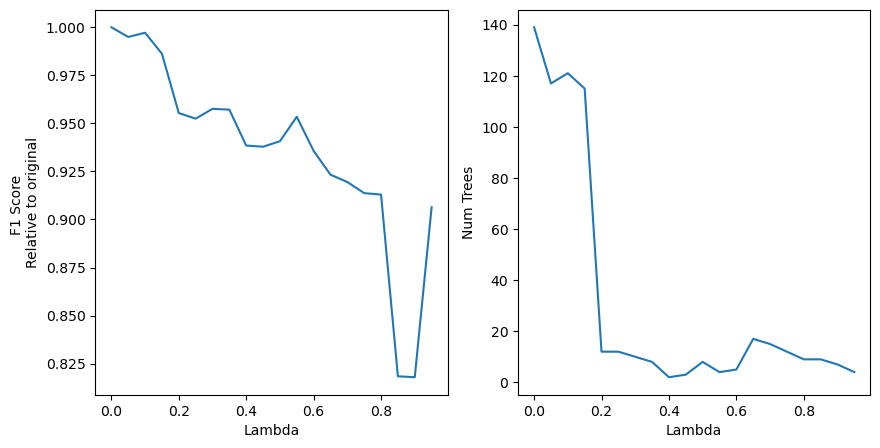

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(lams, [score/scores[0] for score in scores])
axs[0].set_xlabel('Lambda')
axs[0].set_ylabel(f'F1 Score \nRelative to original')

axs[1].plot(lams, trees)
axs[1].set_xlabel('Lambda')
axs[1].set_ylabel('Num Trees')

#fig.savefig('../Data/Data/Figures/inprocessing_summary_i.svg')

(0.688812147031986, 1.05)

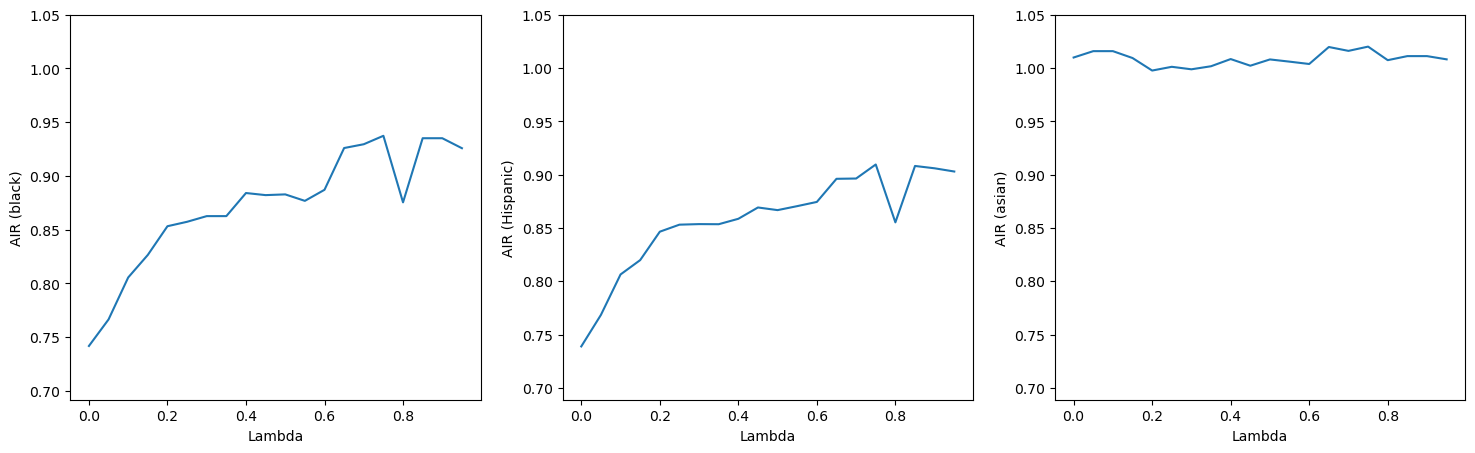

In [55]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs[0].plot(lams, air_black)
axs[0].set_xlabel('Lambda')
axs[0].set_ylabel('AIR (black)')
axs[0].set_ylim((air_black[0]-0.05, 1.05))

axs[1].plot(lams, air_hispanic)
axs[1].set_xlabel('Lambda')
axs[1].set_ylabel('AIR (Hispanic)')
axs[1].set_ylim((air_hispanic[0]-0.05, 1.05))


axs[2].plot(lams, air_asian)
axs[2].set_xlabel('Lambda')
axs[2].set_ylabel('AIR (asian)')
axs[2].set_ylim((air_hispanic[0]-0.05, 1.05))

#fig.savefig('../Data/Data/Figures/inprocessing_summary_ii.png')

In [56]:
# Conduct a similar experiment with the magnitude of the reweighing scheme.

magnitudes = np.arange(0, 1.5, 0.05)
scores = []
trees = []

air_black_ii = []
air_hispanic_ii = [] 
air_asian_ii = [] 

dtest = xgb.DMatrix(test[features], label=test[target])

for mag in magnitudes:
    
    weight_change = 1 - train_weights
    new_train_weights = 1 - mag*weight_change

    dtrain = xgb.DMatrix(train[features], 
                     label=train[target],
                     weight=new_train_weights)


    model = xgb.train(params,         
                      dtrain,                   
                      num_boost_round=200,                     
                      evals=watchlist,
                      early_stopping_rounds=10,
                      verbose_eval=False)
    
    model_metrics = perf_metrics(y_true=valid[target], 
                                 y_score=model.predict(dvalid, iteration_range=(0, model.best_iteration)))
    best_cut = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']

    test[f'p_{target}_lam_test'] = model.predict(dtest, iteration_range=(0, model.best_iteration))

    air_table = fair_lending_disparity(test, y=target, yhat=f'p_{target}_lam_test', 
                                       demo_name='RACE', groups=race_levels, reference_group='white', 
                                       cutoff=best_cut)
    
    scores.append(model_metrics['f1'].max())
    trees.append(model.best_ntree_limit)
    
    air_black_ii.append(air_table.loc['black']['AIR'])
    air_hispanic_ii.append(air_table.loc['hispanic']['AIR'])
    air_asian_ii.append(air_table.loc['asian']['AIR'])
    

Text(0, 0.5, 'Num Trees')

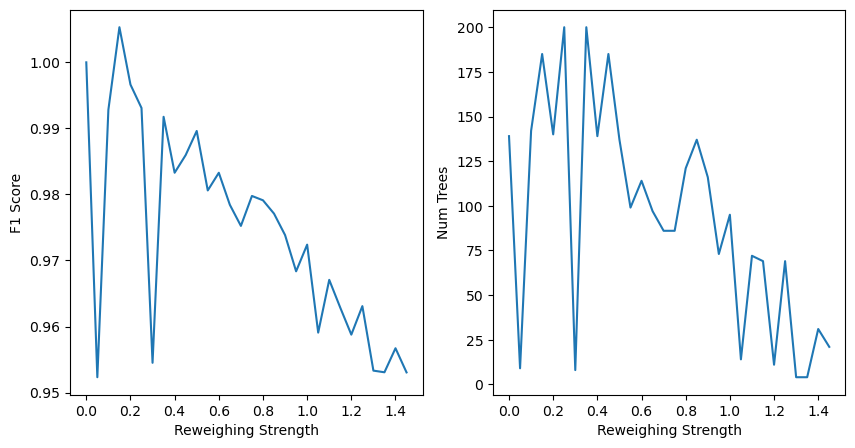

In [57]:
# This plot shows a relative drop in F1 score down to 94% of the original value. 
#  Meanwhile, black and Hispanic AIRs go from 0.72 to 0.9!

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(magnitudes, [score/scores[0] for score in scores])
axs[0].set_xlabel('Reweighing Strength')
axs[0].set_ylabel('F1 Score')

axs[1].plot(magnitudes, trees)
axs[1].set_xlabel('Reweighing Strength')
axs[1].set_ylabel('Num Trees')

#fig.savefig('../Data/Data/Figures/preprocessing_summary_i.svg')

(0.688812147031986, 1.05)

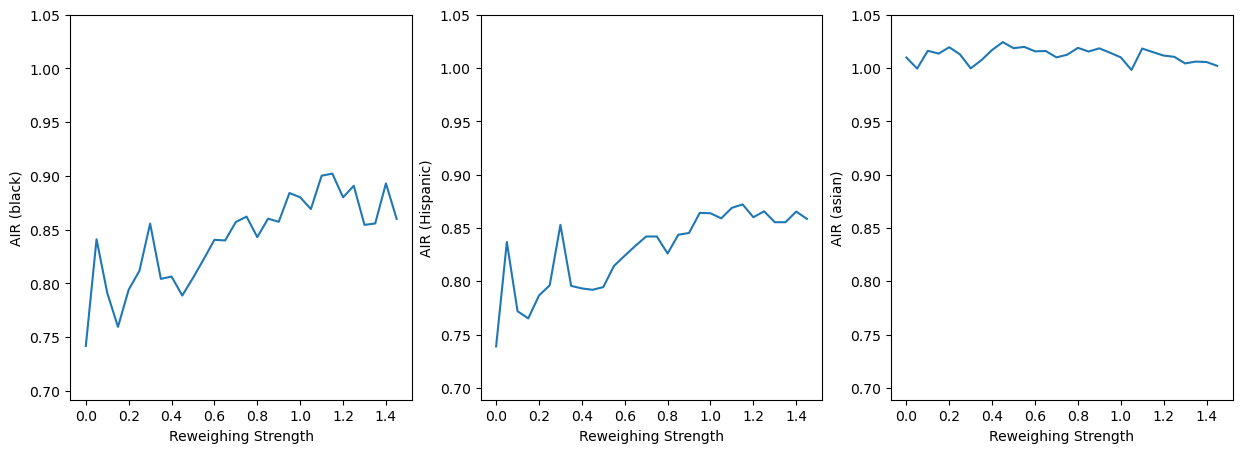

In [58]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(magnitudes, air_black_ii)
axs[0].set_xlabel('Reweighing Strength')
axs[0].set_ylabel('AIR (black)')
axs[0].set_ylim((air_black_ii[0]-0.05, 1.05))

axs[1].plot(magnitudes, air_hispanic_ii)
axs[1].set_xlabel('Reweighing Strength')
axs[1].set_ylabel('AIR (Hispanic)')
axs[1].set_ylim((air_hispanic_ii[0]-0.05, 1.05))

axs[2].plot(magnitudes, air_asian_ii)
axs[2].set_xlabel('Reweighing Strength')
axs[2].set_ylabel('AIR (asian)')
axs[2].set_ylim((air_hispanic[0]-0.05, 1.05))

#fig.savefig('../Data/Data/Figures/preprocessing_summary_ii.png')

### Post-Processing

In [59]:
def reject_option_classification(frame, y_hat, demo_name, protected_groups, reference_group, 
                                 cutoff, uncertainty_region_size, favorable_outcome=0):
    """
    In an uncertainty region around the decision cutoff value, flip protected group predictions to the 
    favorable decision and reference group predictions to the unfavorable decision.
    """
    new_predictions = frame[y_hat].values.copy()
    
    uncertain = np.where(np.abs(frame[y_hat] - cutoff) <= uncertainty_region_size, 1, 0)
    uncertain_protected = np.where(uncertain & frame[demo_name].isin(protected_groups), 1, 0)
    uncertain_reference = np.where(uncertain & (frame[demo_name] == reference_group), 1, 0)
    
    eps = 1e-3
    
    if favorable_outcome == 0:
        new_predictions = np.where(uncertain_protected, 
                                   cutoff - uncertainty_region_size - eps,
                                   new_predictions)
        new_predictions = np.where(uncertain_reference, 
                                   cutoff + uncertainty_region_size + eps,
                                   new_predictions)
    else:
        new_predictions = np.where(uncertain_protected, 
                                   cutoff + uncertainty_region_size + eps,
                                   new_predictions)
        new_predictions = np.where(uncertain_reference, 
                                   cutoff - uncertainty_region_size - eps,
                                   new_predictions)
        
    return new_predictions

In [60]:
train['p_DELINQ_NEXT_postprocessed'] = reject_option_classification(train, 'p_DELINQ_NEXT', 
                                                                    'RACE', ['black', 'hispanic'], 'white', 
                                                                    best_cut_original, uncertainty_region_size=0.05, 
                                                                    favorable_outcome=0)

valid['p_DELINQ_NEXT_postprocessed'] = reject_option_classification(valid, 'p_DELINQ_NEXT', 
                                                                    'RACE', ['black', 'hispanic'], 'white', 
                                                                    best_cut_original, uncertainty_region_size=0.05, 
                                                                    favorable_outcome=0)

test['p_DELINQ_NEXT_postprocessed'] = reject_option_classification(test, 'p_DELINQ_NEXT', 
                                                                    'RACE', ['black', 'hispanic'], 'white', 
                                                                    best_cut_original, uncertainty_region_size=0.05, 
                                                                    favorable_outcome=0)

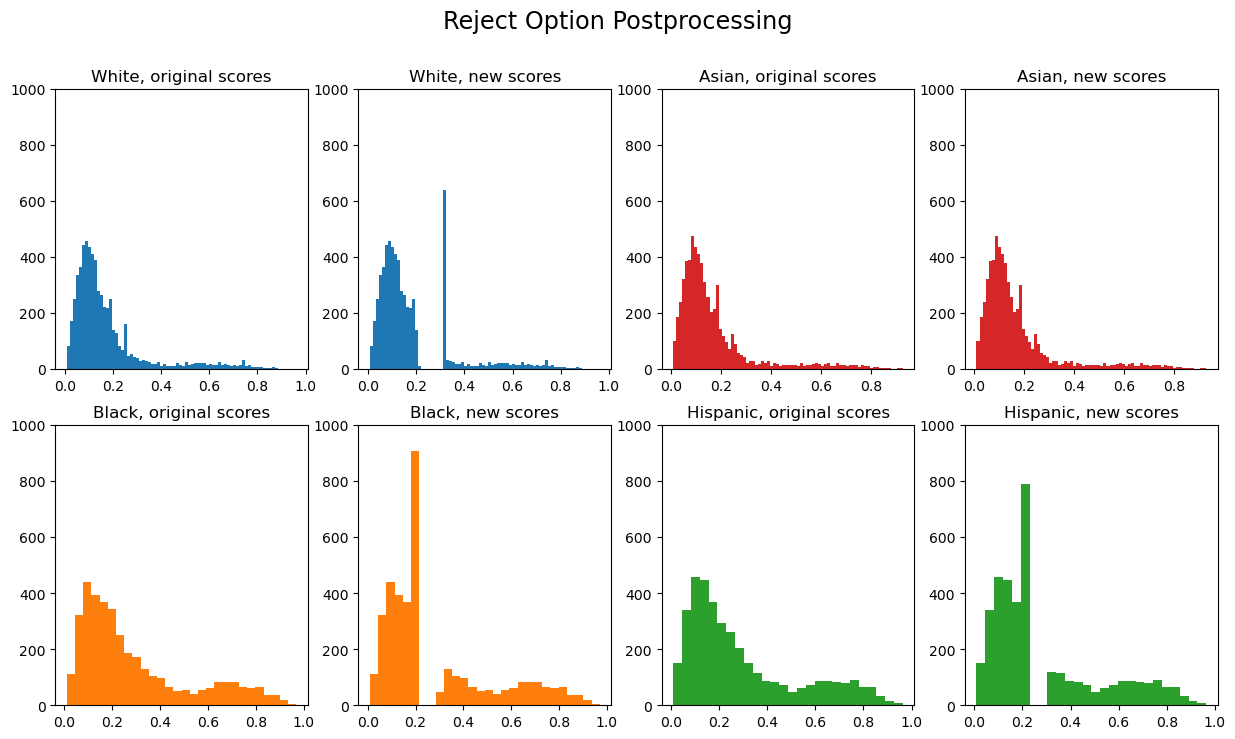

In [61]:
fig, axs = plt.subplots(2, 4, figsize=(15, 8))

fig.suptitle('Reject Option Postprocessing', size='xx-large')

axs[0, 0].hist(train.loc[train['RACE'] == 'white'][f'p_{target}'], bins='auto', color='C0')
axs[0, 0].set_title('White, original scores')
axs[0, 0].set_ylim([0, 1000])

axs[0, 1].hist(train.loc[train['RACE'] == 'white'][f'p_{target}_postprocessed'], bins='auto', color='C0')
axs[0, 1].set_ylim([0, 1000])
axs[0, 1].set_title('White, new scores')


axs[1, 0].hist(train.loc[train['RACE'] == 'black'][f'p_{target}'], bins='auto', color='C1')
axs[1, 0].set_title('Black, original scores')
axs[1, 0].set_ylim([0, 1000])

axs[1, 1].hist(train.loc[train['RACE'] == 'black'][f'p_{target}_postprocessed'], bins='auto', color='C1')
axs[1, 1].set_ylim([0, 1000])
axs[1, 1].set_title('Black, new scores')


axs[1, 2].hist(train.loc[train['RACE'] == 'hispanic'][f'p_{target}'], bins='auto', color='C2')
axs[1, 2].set_title('Hispanic, original scores')
axs[1, 2].set_ylim([0, 1000])

axs[1, 3].hist(train.loc[train['RACE'] == 'hispanic'][f'p_{target}_postprocessed'], bins='auto', color='C2')
axs[1, 3].set_title('Hispanic, new scores')
axs[1, 3].set_ylim([0, 1000])


axs[0, 2].hist(train.loc[train['RACE'] == 'asian'][f'p_{target}'], bins='auto', color='C3')
axs[0, 2].set_title('Asian, original scores')
axs[0, 2].set_ylim([0, 1000])

axs[0, 3].hist(train.loc[train['RACE'] == 'asian'][f'p_{target}_postprocessed'], bins='auto', color='C3')
axs[0, 3].set_ylim([0, 1000])
_ = axs[0, 3].set_title('Asian, new scores')

#fig.savefig('../Data/Data/Figures/postprocessing_example.svg')
fig.savefig('postprocessing_example.svg')


In [62]:
fair_lending_disparity(valid, y=target, yhat=f'p_{target}_postprocessed', 
                       demo_name='RACE', groups=race_levels, reference_group='white', 
                       cutoff=best_cut)

,Count,Favorable Outcomes,Favorable Rate,Mean Score,Std Score,AIR,AIR p-value,SMD,SMD p-value
hispanic,1016,688,0.677165,0.281942,0.205303,0.901735,0.000053,0.432457,5.569972e-25
black,1008,699,0.693452,0.273446,0.204215,0.923424,0.001597,0.393161,8.345200e-21
asian,1455,1158,0.795876,0.187016,0.176762,1.059815,0.003736,-0.034743,8.301511e-01
white,1566,1176,0.750958,0.193157,0.178625,1.000000,1.000000,0.000000,5.000000e-01


In [63]:
metrics = perf_metrics(y_true=valid[target], 
                       y_score=valid[f'p_{target}_postprocessed'])

metrics.loc[metrics['cutoff'] == best_cut_original]


,cutoff,recall,precision,f1
26,0.26,0.569939,0.515318,0.541254


## 4. Model Selection

### Feature Selection

Feature selection is a powerful technique for debiasing. We'll use the adversarial model we've already trained to inform which features we should drop.

In [64]:
adversarial_shap_values = pd.DataFrame(shap.TreeExplainer(adversary_model).shap_values(explanation_data[features]),
                                      columns=features)

In [65]:
# We'll examine the effect of dropping some of these features on model performance and adverse impact ratios.

features_to_drop = ['original model'] + list(adversarial_shap_values.abs().mean().sort_values(ascending=False).head(5).index)

In [66]:
num_cv_folds = 5

# Build the custom cross-validation iterable.
all_indices = np.arange(0, len(train))
all_indices = np.random.permutation(all_indices)
splits = np.array([int(np.floor(len(train)/num_cv_folds)) for _ in range(num_cv_folds-1)])
splits = np.append(splits, len(train) - splits.sum())

test_indices = np.split(all_indices, splits.cumsum())[:-1]
test_groups = [train.iloc[test_ind]['RACE'].values for test_ind in test_indices]

train_indices = [np.array([i for i in all_indices if i not in test_ind]) for test_ind in test_indices]

In [67]:
feature_selection_results = pd.DataFrame(index=features_to_drop, 
                                         columns=['AUC', 'Black AIR', 'Hispanic AIR'])

for dropped_feature in features_to_drop:
    
    new_features = list(set(features).difference(set([dropped_feature])))
    
    cv_auc = []
    cv_black_air = [] 
    cv_hispanic_air = [] 

    for fold_num, (train_ind, test_ind) in enumerate(zip(train_indices, test_indices)):

        new_monotone_constraints={k: v for k, v in dict(zip(features, monotone_constraints)).items() if k != dropped_feature}

        cv_model = xgb.XGBClassifier(n_estimators=150,
                                     max_depth=5,
                                     learning_rate=0.05,
                                     subsample=0.6,
                                     colsample_bytree=1.0,
                                     monotone_constraints=new_monotone_constraints,
                                     random_state=12345, 
                                     use_label_encoder=False,
                                     base_score=params['base_score'],
                                     eval_metric='logloss')

        train_slice = train.reset_index(drop=True).iloc[train_ind].copy()
        test_slice = train.reset_index(drop=True).iloc[test_ind].copy()
        
        cv_model = cv_model.fit(train_slice[new_features],
                                train_slice[target])
        y_pred = cv_model.predict_proba(test_slice[new_features])[:, 1]


        model_metrics = perf_metrics(y_true=train[target].values[test_ind], y_score=y_pred)
        best_cut = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']

        cv_auc.append(sklearn.metrics.roc_auc_score(y_true=train[target].values[test_ind], 
                                                    y_score=y_pred))

        test_slice['pred'] = y_pred
        disparity_table = fair_lending_disparity(test_slice, y=target, yhat=f'pred', 
                           demo_name='RACE', groups=race_levels, reference_group='white', 
                           cutoff=best_cut)

        cv_black_air.append(disparity_table.loc['black']['AIR'])
        cv_hispanic_air.append(disparity_table.loc['hispanic']['AIR'])
        
    feature_selection_results.loc[dropped_feature] = [np.mean(cv_auc), 
                                                      np.mean(cv_black_air), 
                                                      np.mean(cv_hispanic_air)]

In [68]:
feature_to_drop = feature_selection_results.sort_values('Black AIR').index[-1]
feature_to_drop

'PAY_AMT1'

In [69]:
feature_selection_results.sort_values('Black AIR')

,AUC,Black AIR,Hispanic AIR
PAY_AMT6,0.792372,0.721479,0.700829
LIMIT_BAL,0.786607,0.732009,0.730565
BILL_AMT6,0.7913,0.736047,0.723405
original model,0.793276,0.736069,0.717368
PAY_AMT5,0.79124,0.746043,0.731559
PAY_AMT1,0.792777,0.754793,0.743119


In [70]:
new_features = list(set(features).difference(set(['PAY_AMT5'])))
new_monotone_constraints={k: v for k, v in dict(zip(features, monotone_constraints)).items() if k in new_features}

### Hyperparameter Tuning

In [71]:
parameter_distributions = {
    'n_estimators': np.arange(10, 221, 30),
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.7, 0.3),
    'colsample_bytree': stats.uniform(0.5, 0.5),
    'reg_lambda': stats.uniform(0.1, 50),
    'monotone_constraints': [new_monotone_constraints],
    'base_score': [params['base_score']]
    }

In [72]:
fold_number = -1

def black_air(y_true, y_pred):
    
    global fold_number
    fold_number = (fold_number + 1) % num_cv_folds

    model_metrics = perf_metrics(y_true, y_score=y_pred)
    best_cut = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']

    data = pd.DataFrame({'RACE': test_groups[fold_number],
                        'y_true': y_true,
                        'y_pred': y_pred},
                        index=np.arange(len(y_pred)))

    disparity_table = fair_lending_disparity(data, y='y_true', yhat='y_pred', 
                       demo_name='RACE', groups=race_levels, reference_group='white', 
                       cutoff=best_cut)

    return disparity_table.loc['black']['AIR']


def hispanic_air(y_true, y_pred):
    
    global fold_number
    
    model_metrics = perf_metrics(y_true, y_score=y_pred)
    best_cut = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']
    
    data = pd.DataFrame({'RACE': test_groups[fold_number],
                        'y_true': y_true,
                        'y_pred': y_pred},
                        index=np.arange(len(y_pred)))

    disparity_table = fair_lending_disparity(data, y='y_true', yhat='y_pred', 
                       demo_name='RACE', groups=race_levels, reference_group='white', 
                       cutoff=best_cut)

    return disparity_table.loc['hispanic']['AIR']

scoring = {
        'AUC': 'roc_auc',
        'Black AIR': sklearn.metrics.make_scorer(black_air, needs_proba=True),
        'Hispanic AIR': sklearn.metrics.make_scorer(hispanic_air, needs_proba=True)
    }

In [73]:
grid_search = sklearn.model_selection.RandomizedSearchCV(xgb.XGBClassifier(random_state=12345, 
                                                                           use_label_encoder=False,
                                                                           eval_metric='logloss'), 
                                                         parameter_distributions, 
                                                         n_iter=50, 
                                                         scoring=scoring, 
                                                         cv=zip(train_indices, test_indices),
                                                         refit=False,
                                                         error_score='raise').fit(train[new_features], train[target].values)
results = pd.DataFrame(grid_search.cv_results_)

Text(0, 0.5, 'AUC (normalized)')

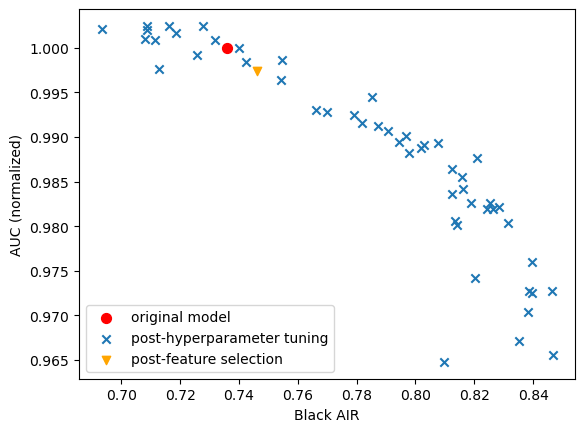

In [74]:
original_auc = feature_selection_results.loc['original model']['AUC']
original_black_air = feature_selection_results.loc['original model']['Black AIR']

new_auc = feature_selection_results.loc['PAY_AMT5']['AUC']
new_black_air = feature_selection_results.loc['PAY_AMT5']['Black AIR']

fig, ax = plt.subplots()
ax.scatter(original_black_air, 1.0, s=50, color='red', label='original model')
ax.scatter(results['mean_test_Black AIR'], results['mean_test_AUC']/original_auc, label='post-hyperparameter tuning', marker='x')
ax.scatter(new_black_air, new_auc/original_auc, color='orange', label='post-feature selection', marker='v')
ax.legend(loc='lower left')
ax.set_xlabel('Black AIR')
ax.set_ylabel('AUC (normalized)')

#fig.savefig('../Data/Data/Figures/model_tuning_scatter.svg', dpi=300)

In [75]:

results[['mean_test_Black AIR', 'mean_test_Hispanic AIR', 'mean_test_AUC']].sort_values(['mean_test_Black AIR', 'mean_test_AUC'], ascending=False)

highest_air_idx = results.loc[results['mean_test_Black AIR'] == results['mean_test_Black AIR'].max()].index[0]

# We can also choose the fairest model that demonstrates no more than a 1% decrease in AUC from the original model.
business_viable_models = results.loc[results['mean_test_AUC'] >= 0.99*original_auc]
alternative_model_idx = business_viable_models.loc[business_viable_models['mean_test_Black AIR'] == business_viable_models['mean_test_Black AIR'].max()].index[0]


In [76]:
new_hyperparameter_idx = [highest_air_idx, alternative_model_idx]

tuned_params = ['_'.join(col.split('_')[1:]) for col in results.columns if col.startswith('param_')]
new_hyperparameters = [dict(zip(tuned_params, [row[f'param_{param}'] for param in tuned_params])) for _, row in results.loc[new_hyperparameter_idx].iterrows()]

### Conclusion

In [77]:
def model_summary(y_true, y_pred, group_info, reference_group, metric_dict, cutoff,
                  confusion_metrics_to_show=['False Positive Rate']):

    groups = np.unique(group_info)
    protected_groups = [group for group in groups if group != reference_group]
    
    model_metrics = perf_metrics(y_true, y_score=y_pred)
    # best_cut = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']
    # f1 = model_metrics['f1'].max()

    f1 = model_metrics.loc[model_metrics['cutoff'] == cutoff, 'f1'].values[0]

    auc = sklearn.metrics.roc_auc_score(y_true, y_score=y_pred)
    
    data = pd.DataFrame({'demo': group_info,
                        'y_true': y_true,
                        'y_pred': y_pred},
                        index=np.arange(len(y_pred)))

    disparity_table = fair_lending_disparity(data, y='y_true', yhat='y_pred', 
                       demo_name='demo', groups=groups, reference_group=reference_group, 
                       cutoff=cutoff)

    airs = dict(zip([f'{group} AIR' for group in protected_groups], 
                    [disparity_table.loc[group]['AIR'] for group in protected_groups]))
    
    confusion_mats = {level: get_confusion_matrix(data, 'y_true', 'y_pred', by='demo', 
                                                  level=level, cutoff=cutoff) for level in groups} 
    confusion_metrics = confusion_matrix_metrics(confusion_mats, metric_dict)
    confusion_disparity_frame = confusion_metrics/confusion_metrics.loc[reference_group, :]

    confusion_metric_disparities = dict()
    for metric in confusion_metrics_to_show:
        confusion_metric_disparities.update(dict(zip([f"{group} {metric} Disparity" for group in protected_groups],
                                               [confusion_disparity_frame.loc[group][metric] for group in protected_groups])))
    
    output = {'AUC': auc, 'F1': f1}
    output.update(airs)
    output.update(confusion_metric_disparities)
    
    return pd.Series(output)

In [78]:

feature_selection_model = xgb.XGBClassifier(n_estimators=150,
                                     max_depth=5,
                                     learning_rate=0.05,
                                     subsample=0.6,
                                     colsample_bytree=1.0,
                                     monotone_constraints=new_monotone_constraints,
                                     random_state=12345, 
                                     use_label_encoder=False,
                                     base_score=params['base_score'],
                                     eval_metric='logloss').fit(train[new_features], train[target])

model_metrics = perf_metrics(y_true=valid[target], 
                             y_score=feature_selection_model.predict_proba(valid[new_features])[:, 1])
best_cut_feature_selection = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']

hyp_tuning_model_1 = xgb.XGBClassifier(random_state=12345, 
                                     use_label_encoder=False,
                                     eval_metric='logloss', **new_hyperparameters[0]).fit(train[new_features], train[target])

model_metrics = perf_metrics(y_true=valid[target], 
                             y_score=hyp_tuning_model_1.predict_proba(valid[new_features])[:, 1])
best_cut_hyp_1 = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']

hyp_tuning_model_2 = xgb.XGBClassifier(random_state=12345, 
                                     use_label_encoder=False,
                                     eval_metric='logloss', **new_hyperparameters[1]).fit(train[new_features], train[target])


model_metrics = perf_metrics(y_true=valid[target], 
                             y_score=hyp_tuning_model_2.predict_proba(valid[new_features])[:, 1])
best_cut_hyp_2 = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']


In [79]:
model_predictions = {'Original Model': (test[f"p_{target}"].values, best_cut_original),
                    'Pre-processing (reweighting)': (test[f'p_{target}_reweighted'].values, reweighted_best_cut), 
                    'In-processing (regularized, lam = 0.2)': (test[f'p_{target}_regularized'].values, best_cut_regularized), 
                    'Post-processing (reject option, window size = 0.1)': (test[f'p_{target}_postprocessed'].values, best_cut_original),
                    'Feature selection': (feature_selection_model.predict_proba(test[new_features])[:, 1], best_cut_feature_selection), 
                    'Hyperparameter tuning #1': (hyp_tuning_model_1.predict_proba(test[new_features])[:, 1], best_cut_hyp_1), 
                    'Hyperparameter tuning #2': (hyp_tuning_model_2.predict_proba(test[new_features])[:, 1], best_cut_hyp_2)}

In [80]:
model_summaries = {name: model_summary(test[target].values, pred, test['RACE'].values, 'white', metric_dict, cutoff) for name, (pred, cutoff) in model_predictions.items()}

In [81]:
pd.DataFrame(model_summaries)

,Original Model,Pre-processing (reweighting),"In-processing (regularized, lam = 0.2)","Post-processing (reject option, window size = 0.1)",Feature selection,Hyperparameter tuning #1,Hyperparameter tuning #2
AUC,0.798021,0.774183,0.764005,0.794894,0.795877,0.763696,0.789032
F1,0.558874,0.543758,0.515971,0.533964,0.551754,0.528425,0.550215
asian AIR,1.012274,1.010014,1.001185,1.107676,1.006445,0.998179,1.016789
black AIR,0.735836,0.877673,0.851499,0.901386,0.760412,0.860003,0.812957
hispanic AIR,0.736394,0.861252,0.851045,0.882538,0.745280,0.839462,0.802558
asian False Positive Rate Disparity,0.872567,0.929948,0.986472,0.575248,0.916817,0.944494,0.896505
black False Positive Rate Disparity,1.783528,0.956640,1.141044,0.852034,1.617929,1.028456,1.352551
hispanic False Positive Rate Disparity,1.696062,0.899065,1.000040,0.786195,1.645826,1.151545,1.256332
